In [11]:
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.patches as patches
from matplotlib.table import Table

# Question 1
### The n-queens problem involves placing n queens on an n x n chessboard such that no two queens threaten each other. A queen can attack another queen if they are in the same row, column, or diagonal. The goal is to find a configuration where no queens threaten each other.

#### (1) Define a chromosome and decide on an appropriate representation for the queens’ positions on the chessboard.

In [12]:
# we assume that the number of queen are 8 at the begining
# the final solution of the app is relatable to any number of n
n = 8
# we use the permutation data structure for representation and we assume that there's only one queen in each row
# the index number equals the row
# so each chromosom is an array with the lengh of n and each value represents the position of queen in the specified row
# by doing so no queen can threaten any other horizontally or vertically
# a choromosom would look like below
# which is a permutation of 0 to n
# the values are between 0 and n for the sake of simplicity
chromosom = [i for i in range(n)]


#### (2) Design a fitness function that evaluates the quality of a solution based on the number of non-attacking pairs of queens.

In [13]:
# because of the datastructre which is permutation we only need to check for diagonal threats
# the fitness function returns the number of threatened queens
# 0 fitness means no queens are threated
# since we need the best fitness to be more than other values we subtract maximum number of threats from the number of thretened queen
# so in this case of n = 8 the best fitness is 64
def fitness(chromosom: list):
    fitness = 0
    # we check for the diagonal threat by calculating the distance in x and y axis if the distances are the same the two queens are on the same diagonal
    for i,first_chromosom in enumerate(chromosom):
        for j, second_chromosom in enumerate(chromosom):
            if i == j : continue
            d_x = abs(first_chromosom - second_chromosom)
            d_y = abs(i - j)
            if(d_x == d_y):
                fitness+=1
    return (len(chromosom)**2) - fitness

#### (3) Implement a crossover mechanism that combines segments of two parent chromosomes to produce offspring.

In [14]:
# we PMX crossover for the crossover mechanism

def PMX_one_offspring(p1, p2, cutoff_1, cutoff_2):
        offspring = np.zeros(len(p1), dtype=p1.dtype)

        # Copy the mapping section (middle) from parent1
        offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]

        # copy the rest from parent2 (provided it's not already there
        for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
            candidate = p2[i]
            while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
                # print(f"Candidate {candidate} not valid in position {i}") # DEBUGONLY
                candidate = p2[np.where(p1 == candidate)[0][0]]
            offspring[i] = candidate
        return offspring


def PMX_crossover(parent1, parent2, seed):
    '''
    parent1 and parent2 are 1D np.array
    '''
    rng = np.random.default_rng(seed=seed)

    cutoff_1, cutoff_2 = np.sort(rng.choice(np.arange(len(parent1)+1), size=2, replace=False))

    offspring1 = PMX_one_offspring(parent1, parent2, cutoff_1, cutoff_2)
    offspring2 = PMX_one_offspring(parent2, parent1, cutoff_1, cutoff_2)

    offspring1 = offspring1.tolist()
    offspring2 = offspring2.tolist()

    return offspring1, offspring2

#### (4) Implement a mutation mechanism that alters parts of a chromosome to maintain diversity in the population.

In [15]:
# for mutation we use inverse mutation
def mutate(chromosom: list, n: int):
    # Choose mutation points
    mutation_point_1 = random.randint(0, n)
    mutation_point_2 = random.randint(0, n - 1)
    if mutation_point_2 >= mutation_point_1:
        mutation_point_2 += 1
    else:  # Swap the two mutation points
        mutation_point_1, mutation_point_2 = mutation_point_2, mutation_point_1
    inversion_list: list = chromosom[mutation_point_1: mutation_point_2]
    inversion_list.reverse()
    chromosom[mutation_point_1: mutation_point_2]= inversion_list
    return chromosom

#### (5) Use a selection method to choose parents for crossover based on their fitness values

In [16]:
def parent_selection(population: list[list], fitnesses: list, population_limit: int):
    selected_parents_indexes = [0] * population_limit
    selection_probability = [{"chromosom_sel_prob": (fitnesses[i]/sum(fitnesses)), "index":i} for i,chromosom in enumerate(population)]
    selection_probability.sort(key=lambda item: item["chromosom_sel_prob"])
    for i in range(len (selection_probability)):
        if i == 0: continue
        selection_probability[i]["chromosom_sel_prob"] += selection_probability[i-1]["chromosom_sel_prob"]
    for i in range(population_limit):
        random_val = random.uniform(0,1)
        for chromosom_sel_prob in selection_probability:
            if chromosom_sel_prob["chromosom_sel_prob"] < random_val: continue
            selected_parents_indexes[i] = chromosom_sel_prob["index"]
            break
    selected_parents = [population[parent_index] for parent_index in selected_parents_indexes]
    return selected_parents

#### Create a way to visualize the solution on a chessboard at different stages of the algorithm.

In [17]:
def plot_solution(solutions, n) -> None:
    """Given a solution, plot it and save the result to disk."""
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, n))
    ax.set_ylim((0, n))

    count = 0
    plt.grid()
    for solution in solutions:
        for queen in solution:
            ax.add_patch(patches.Rectangle((queen, count), 1, 1))
            count += 1
        plt.show()

#### (6) Set up the workflow for the genetic algorithm, including the generation of the initial population, iterative application of genetic operators, and the termination condition.

In [18]:
def genetic_n_queens(n: int, initial_population: int, chromosom: list):
    population = [np.random.permutation(chromosom) for i in range(initial_population)]
    fitnesses = [fitness(individual) for individual in population]
    if (n**2) in fitnesses:
        return population[fitnesses.index(64)]
    while (n**2) not in fitnesses:
        print("new generation ... ")
        offsprings = []
        print("recombination ...")
        for i, chromosom1 in enumerate(population):
            for j, chromosom2 in enumerate(population):
                if i == j : continue
                offspring1, offspring2 = PMX_crossover(np.array(chromosom1), np.array(chromosom2), n)
                offsprings.append(offspring1)
                offsprings.append(offspring2)
        population.extend(offsprings)
        population = np.array(population)
        population = population.tolist()
        offsprings = []
        print("mutations ... ")
        for i, parent_mutate in enumerate(population):
            mutate_prob = random.randint(0,1)
            if mutate_prob == 1:
                offspring_mutate = mutate(parent_mutate, n)
                offsprings.append(offspring_mutate)
        population.extend(offsprings)
        population = np.array(population)
        population = population.tolist()
        fitnesses = [fitness(individual) for individual in population]
        population = parent_selection(population, fitnesses, initial_population)
        fitnesses = [fitness(individual) for individual in population]
        print(population)
        plot_solution(population,n)
    
    return population[fitnesses.index(64)]
    


new generation ... 
recombination ...
mutations ... 
[[2, 0, 1, 3, 6, 4, 7, 5], [1, 5, 2, 3, 7, 6, 0, 4], [1, 6, 0, 4, 5, 7, 3, 2], [4, 1, 3, 6, 2, 0, 5, 7], [4, 5, 0, 6, 7, 2, 1, 3], [4, 3, 0, 7, 2, 6, 1, 5], [2, 0, 1, 3, 6, 4, 7, 5], [1, 2, 3, 6, 5, 7, 4, 0], [2, 3, 0, 4, 5, 6, 7, 1], [6, 5, 2, 3, 7, 0, 1, 4]]


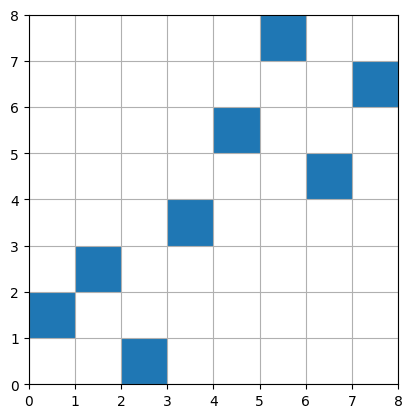

new generation ... 
recombination ...
mutations ... 
[[4, 2, 1, 3, 6, 0, 5, 7], [1, 5, 0, 7, 2, 6, 3, 4], [2, 5, 1, 3, 6, 7, 4, 0], [4, 1, 2, 3, 7, 0, 5, 6], [2, 1, 0, 4, 5, 3, 7, 6], [2, 0, 1, 3, 6, 4, 7, 5], [4, 5, 1, 3, 6, 2, 0, 7], [6, 1, 0, 2, 7, 4, 3, 5], [4, 2, 1, 3, 6, 0, 5, 7], [1, 2, 0, 4, 5, 7, 6, 3]]


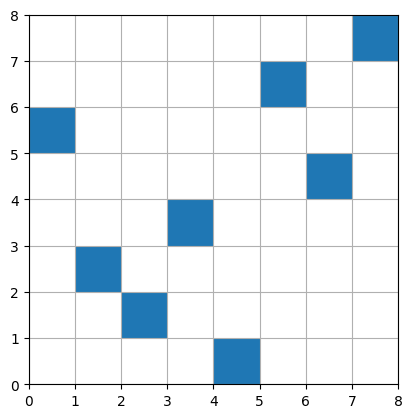

new generation ... 
recombination ...
mutations ... 
[[1, 2, 0, 4, 5, 7, 3, 6], [3, 1, 0, 2, 7, 6, 4, 5], [1, 5, 2, 3, 7, 6, 4, 0], [2, 0, 1, 3, 6, 7, 5, 4], [4, 2, 1, 3, 6, 0, 5, 7], [0, 2, 1, 7, 6, 3, 5, 4], [4, 2, 1, 3, 6, 0, 5, 7], [2, 0, 1, 3, 6, 7, 4, 5], [1, 2, 4, 3, 6, 0, 5, 7], [4, 5, 1, 7, 0, 2, 6, 3]]


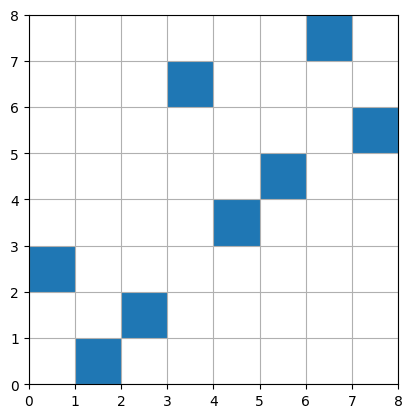

new generation ... 
recombination ...
mutations ... 
[[1, 4, 0, 2, 5, 3, 6, 7], [1, 4, 2, 3, 7, 0, 5, 6], [7, 3, 2, 1, 4, 0, 5, 6], [0, 4, 7, 6, 3, 1, 2, 5], [2, 5, 4, 7, 6, 3, 1, 0], [2, 6, 1, 4, 3, 0, 7, 5], [0, 2, 1, 6, 3, 7, 5, 4], [4, 5, 0, 6, 3, 1, 2, 7], [2, 0, 1, 5, 3, 6, 7, 4], [2, 0, 1, 7, 6, 3, 4, 5]]


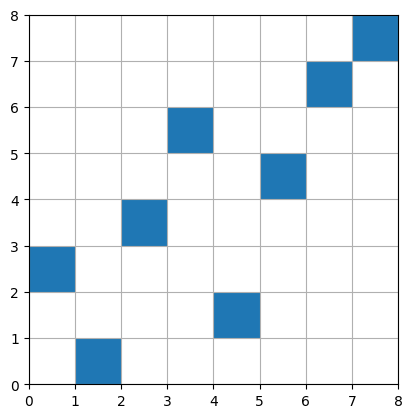

new generation ... 
recombination ...
mutations ... 
[[0, 3, 4, 1, 2, 5, 6, 7], [1, 4, 7, 6, 3, 5, 2, 0], [5, 0, 6, 7, 1, 4, 2, 3], [1, 4, 3, 6, 0, 2, 5, 7], [2, 3, 4, 7, 6, 0, 1, 5], [2, 7, 1, 5, 3, 6, 4, 0], [1, 2, 3, 0, 4, 6, 7, 5], [4, 6, 1, 5, 3, 0, 2, 7], [1, 0, 5, 3, 6, 7, 4, 2], [0, 2, 7, 6, 3, 1, 5, 4]]


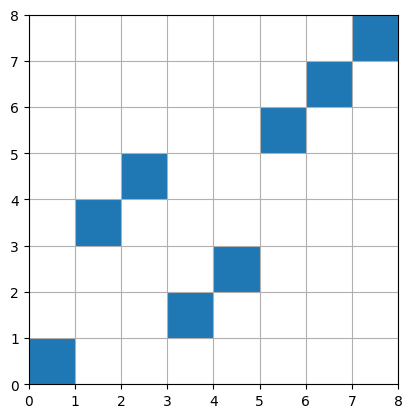

new generation ... 
recombination ...
mutations ... 
[[5, 2, 3, 6, 7, 4, 1, 0], [3, 6, 7, 5, 4, 0, 2, 1], [1, 0, 4, 7, 6, 3, 5, 2], [5, 0, 6, 3, 4, 2, 1, 7], [7, 6, 3, 0, 1, 5, 4, 2], [6, 0, 5, 1, 3, 7, 4, 2], [1, 0, 7, 6, 3, 5, 4, 2], [0, 2, 1, 5, 3, 7, 6, 4], [0, 1, 5, 3, 6, 4, 2, 7], [4, 6, 1, 5, 3, 0, 2, 7]]


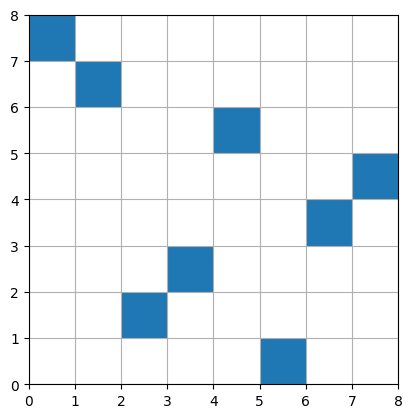

new generation ... 
recombination ...
mutations ... 
[[4, 6, 1, 5, 3, 0, 2, 7], [5, 2, 3, 6, 7, 4, 1, 0], [4, 5, 1, 2, 0, 3, 6, 7], [0, 2, 3, 6, 7, 1, 5, 4], [0, 6, 7, 3, 5, 1, 2, 4], [1, 0, 3, 6, 7, 5, 4, 2], [4, 1, 5, 3, 6, 0, 2, 7], [4, 0, 1, 5, 3, 2, 6, 7], [0, 2, 5, 3, 6, 7, 1, 4], [0, 2, 3, 6, 7, 1, 5, 4]]


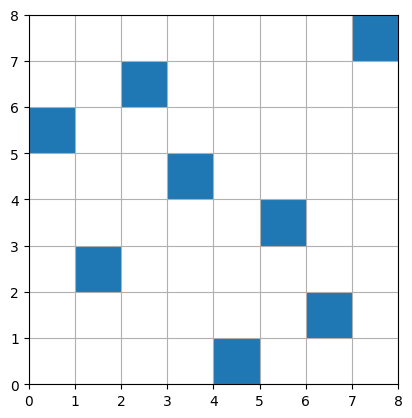

new generation ... 
recombination ...
mutations ... 
[[1, 0, 3, 6, 7, 5, 4, 2], [0, 2, 5, 3, 6, 7, 1, 4], [6, 3, 2, 0, 7, 1, 5, 4], [0, 2, 1, 4, 6, 7, 3, 5], [0, 7, 6, 3, 2, 1, 5, 4], [0, 2, 7, 3, 6, 1, 5, 4], [0, 7, 3, 5, 1, 2, 6, 4], [6, 2, 7, 3, 5, 4, 0, 1], [5, 4, 3, 6, 7, 0, 2, 1], [0, 2, 5, 3, 6, 1, 7, 4]]


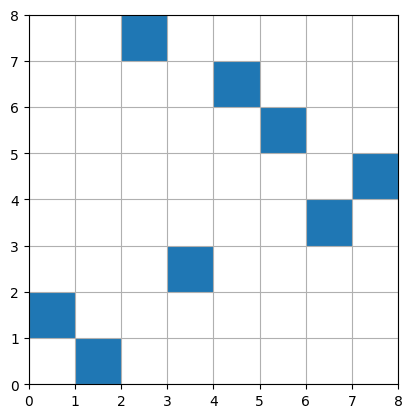

new generation ... 
recombination ...
mutations ... 
[[0, 7, 2, 6, 4, 1, 3, 5], [7, 2, 5, 3, 6, 4, 0, 1], [6, 5, 0, 3, 2, 1, 7, 4], [1, 0, 6, 3, 2, 5, 4, 7], [1, 0, 7, 2, 4, 6, 5, 3], [0, 4, 7, 1, 6, 3, 5, 2], [0, 7, 5, 3, 1, 6, 2, 4], [7, 2, 5, 3, 6, 4, 0, 1], [1, 0, 5, 3, 6, 7, 4, 2], [0, 2, 1, 4, 3, 7, 5, 6]]


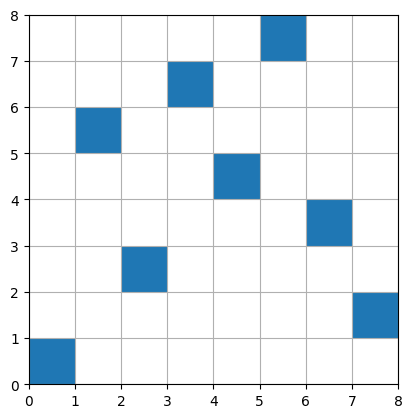

new generation ... 
recombination ...
mutations ... 
[[1, 4, 2, 6, 3, 5, 0, 7], [6, 5, 1, 4, 3, 0, 2, 7], [3, 5, 2, 6, 4, 1, 7, 0], [7, 2, 5, 3, 6, 4, 0, 1], [1, 0, 5, 3, 6, 2, 4, 7], [5, 3, 7, 2, 4, 6, 0, 1], [1, 0, 5, 3, 6, 4, 2, 7], [1, 5, 0, 3, 2, 7, 4, 6], [1, 0, 5, 3, 6, 4, 7, 2], [1, 0, 2, 6, 4, 5, 3, 7]]


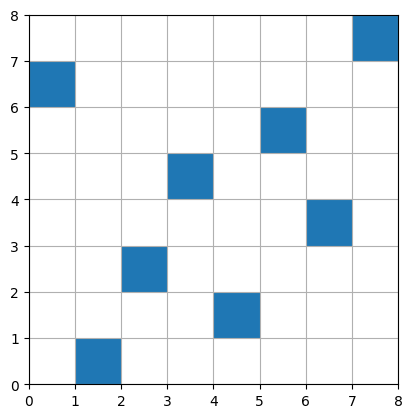

new generation ... 
recombination ...
mutations ... 
[[1, 0, 5, 3, 6, 2, 4, 7], [1, 2, 7, 5, 4, 0, 3, 6], [1, 0, 5, 3, 6, 2, 4, 7], [1, 5, 0, 3, 6, 4, 2, 7], [1, 7, 4, 2, 6, 3, 5, 0], [1, 3, 2, 6, 4, 5, 0, 7], [4, 2, 6, 3, 5, 0, 1, 7], [1, 0, 7, 3, 4, 6, 2, 5], [4, 2, 5, 3, 6, 1, 7, 0], [1, 0, 7, 4, 6, 3, 5, 2]]


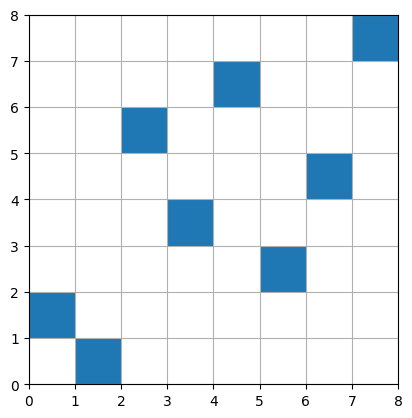

new generation ... 
recombination ...
mutations ... 
[[7, 0, 1, 4, 6, 2, 3, 5], [1, 0, 7, 4, 6, 3, 5, 2], [3, 2, 7, 4, 6, 1, 5, 0], [1, 0, 7, 4, 2, 6, 3, 5], [4, 3, 5, 2, 6, 1, 7, 0], [5, 3, 6, 2, 4, 0, 1, 7], [1, 7, 2, 6, 4, 0, 3, 5], [1, 0, 7, 5, 3, 4, 6, 2], [1, 7, 4, 2, 6, 3, 5, 0], [4, 3, 7, 2, 6, 1, 5, 0]]


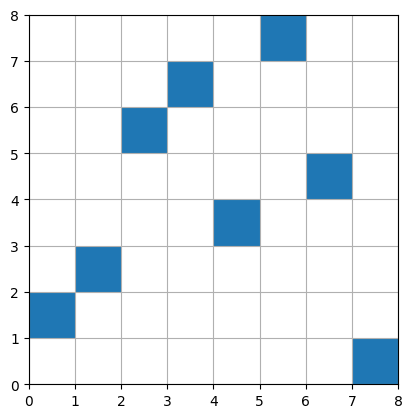

new generation ... 
recombination ...
mutations ... 
[[1, 0, 2, 6, 4, 3, 5, 7], [1, 2, 0, 6, 4, 7, 3, 5], [5, 3, 1, 4, 6, 0, 2, 7], [7, 0, 1, 4, 6, 2, 3, 5], [1, 0, 4, 2, 6, 7, 3, 5], [1, 0, 2, 6, 4, 3, 5, 7], [5, 0, 1, 2, 6, 4, 3, 7], [4, 6, 7, 5, 3, 1, 2, 0], [6, 4, 7, 3, 2, 1, 5, 0], [7, 0, 1, 4, 6, 2, 3, 5]]


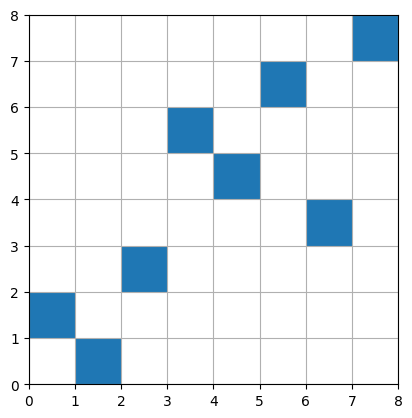

new generation ... 
recombination ...
mutations ... 
[[0, 2, 1, 4, 7, 6, 3, 5], [1, 2, 7, 5, 3, 4, 0, 6], [1, 2, 7, 5, 3, 6, 4, 0], [5, 0, 1, 4, 6, 2, 3, 7], [1, 0, 2, 5, 3, 4, 6, 7], [1, 0, 2, 4, 6, 7, 3, 5], [1, 2, 0, 6, 4, 3, 5, 7], [7, 0, 1, 4, 6, 2, 3, 5], [2, 0, 1, 6, 4, 3, 5, 7], [7, 5, 3, 1, 4, 6, 2, 0]]


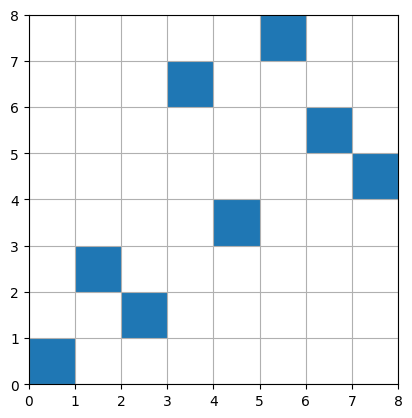

new generation ... 
recombination ...
mutations ... 
[[1, 0, 7, 5, 3, 2, 6, 4], [1, 2, 7, 5, 3, 6, 4, 0], [2, 0, 1, 5, 3, 4, 6, 7], [1, 0, 2, 5, 3, 4, 6, 7], [7, 6, 1, 5, 4, 3, 2, 0], [2, 0, 7, 5, 3, 4, 6, 1], [0, 2, 1, 6, 4, 7, 3, 5], [7, 2, 1, 6, 4, 3, 0, 5], [7, 0, 1, 6, 5, 3, 2, 4], [1, 0, 7, 5, 3, 2, 6, 4]]


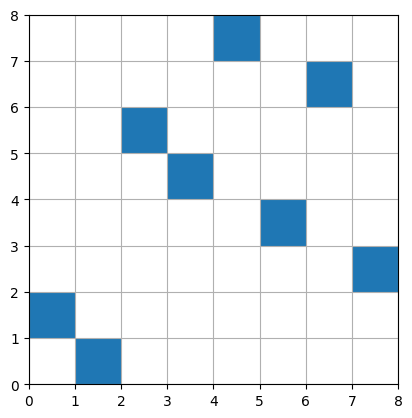

new generation ... 
recombination ...
mutations ... 
[[0, 2, 1, 5, 4, 7, 3, 6], [0, 1, 2, 5, 3, 7, 4, 6], [5, 3, 7, 4, 6, 1, 2, 0], [1, 2, 7, 5, 3, 6, 4, 0], [0, 2, 6, 1, 5, 7, 3, 4], [2, 0, 7, 5, 3, 1, 6, 4], [1, 0, 2, 5, 3, 4, 6, 7], [1, 0, 6, 7, 3, 5, 2, 4], [1, 0, 7, 5, 3, 2, 6, 4], [4, 5, 6, 1, 0, 2, 3, 7]]


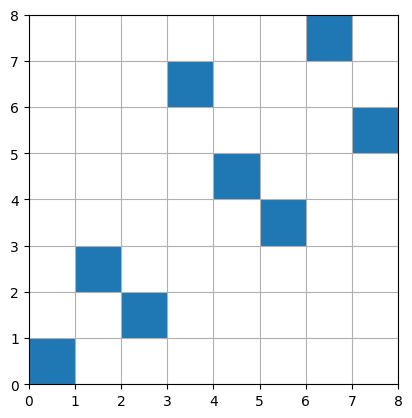

new generation ... 
recombination ...
mutations ... 
[[7, 0, 6, 1, 3, 5, 2, 4], [1, 5, 2, 0, 3, 7, 6, 4], [0, 2, 7, 4, 6, 1, 3, 5], [3, 0, 6, 1, 5, 4, 2, 7], [1, 6, 3, 5, 2, 7, 4, 0], [0, 5, 6, 4, 7, 2, 3, 1], [0, 1, 3, 5, 2, 7, 4, 6], [4, 1, 7, 5, 3, 2, 0, 6], [0, 2, 6, 7, 3, 5, 1, 4], [1, 0, 4, 7, 6, 5, 3, 2]]


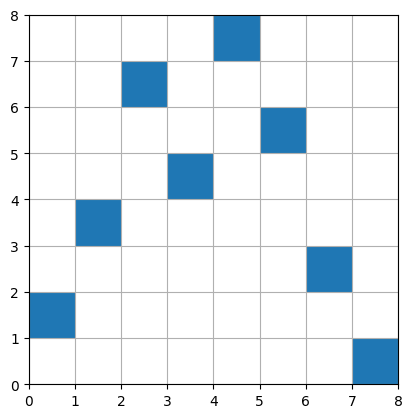

new generation ... 
recombination ...
mutations ... 
[[7, 0, 5, 3, 1, 6, 4, 2], [0, 4, 7, 5, 3, 2, 6, 1], [2, 5, 3, 6, 0, 1, 7, 4], [0, 7, 3, 5, 1, 6, 2, 4], [6, 1, 7, 5, 3, 2, 4, 0], [0, 7, 6, 1, 5, 2, 3, 4], [0, 2, 3, 7, 6, 5, 4, 1], [0, 1, 6, 7, 3, 5, 4, 2], [1, 5, 3, 0, 6, 7, 4, 2], [0, 7, 3, 5, 2, 1, 6, 4]]


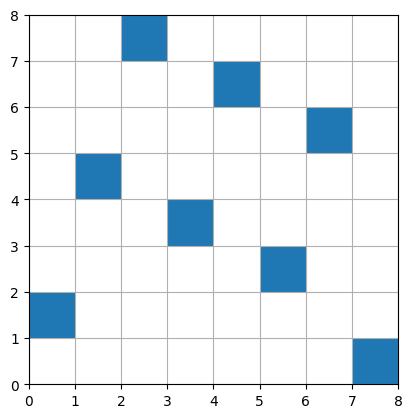

new generation ... 
recombination ...
mutations ... 
[[7, 0, 5, 3, 1, 6, 4, 2], [2, 6, 7, 5, 3, 1, 0, 4], [6, 0, 3, 5, 1, 7, 4, 2], [1, 5, 3, 6, 0, 4, 7, 2], [2, 6, 5, 3, 1, 0, 7, 4], [0, 4, 6, 1, 5, 2, 3, 7], [0, 6, 5, 3, 1, 7, 4, 2], [0, 7, 3, 5, 2, 1, 6, 4], [0, 2, 5, 1, 6, 7, 3, 4], [3, 7, 0, 5, 2, 1, 6, 4]]


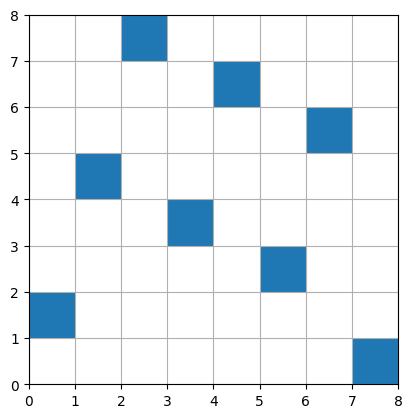

new generation ... 
recombination ...
mutations ... 
[[3, 0, 5, 1, 6, 7, 4, 2], [2, 1, 3, 5, 4, 0, 6, 7], [2, 3, 5, 0, 7, 6, 1, 4], [0, 4, 5, 3, 2, 6, 1, 7], [7, 2, 6, 1, 5, 3, 0, 4], [2, 0, 7, 5, 3, 1, 6, 4], [0, 3, 5, 1, 2, 7, 4, 6], [7, 3, 1, 2, 5, 0, 4, 6], [1, 0, 7, 5, 2, 4, 6, 3], [0, 7, 5, 3, 1, 2, 6, 4]]


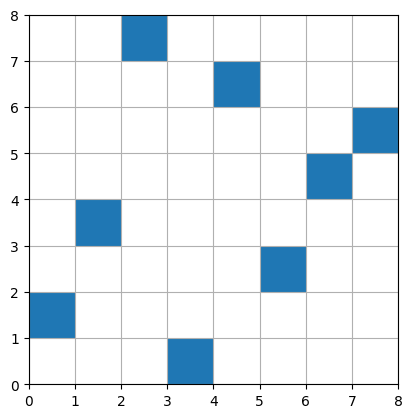

new generation ... 
recombination ...
mutations ... 
[[0, 4, 5, 1, 6, 2, 3, 7], [0, 7, 1, 2, 5, 6, 3, 4], [4, 1, 7, 5, 2, 0, 6, 3], [0, 3, 6, 1, 5, 7, 4, 2], [1, 3, 5, 0, 7, 2, 4, 6], [2, 3, 5, 0, 1, 4, 6, 7], [0, 3, 1, 6, 2, 5, 7, 4], [7, 6, 5, 3, 2, 1, 0, 4], [1, 2, 7, 6, 4, 0, 3, 5], [7, 3, 0, 5, 1, 6, 4, 2]]


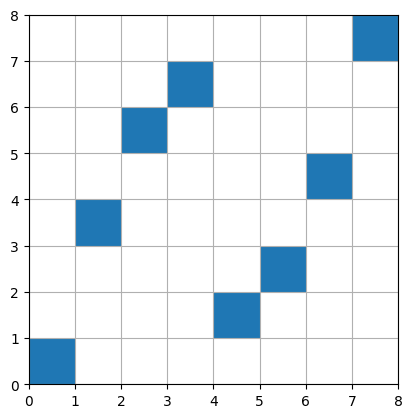

new generation ... 
recombination ...
mutations ... 
[[1, 2, 5, 0, 7, 4, 3, 6], [4, 1, 5, 0, 7, 2, 6, 3], [7, 3, 1, 6, 2, 5, 4, 0], [2, 1, 5, 0, 3, 6, 7, 4], [1, 3, 5, 0, 4, 6, 7, 2], [4, 2, 0, 5, 1, 7, 3, 6], [6, 3, 5, 0, 1, 2, 7, 4], [6, 7, 1, 0, 5, 3, 4, 2], [6, 3, 5, 0, 1, 2, 7, 4], [4, 7, 1, 2, 5, 0, 6, 3]]


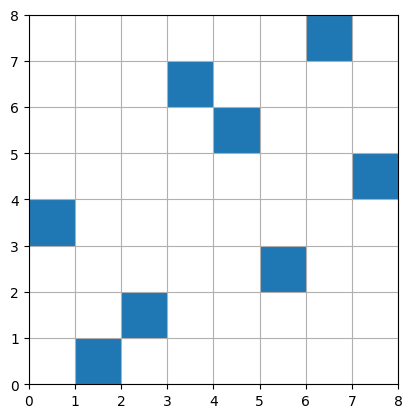

new generation ... 
recombination ...
mutations ... 
[[4, 0, 5, 7, 1, 2, 6, 3], [6, 3, 5, 2, 1, 0, 7, 4], [1, 2, 5, 0, 4, 7, 3, 6], [6, 3, 5, 0, 2, 4, 7, 1], [6, 3, 0, 5, 1, 2, 7, 4], [4, 7, 1, 2, 5, 0, 6, 3], [6, 3, 0, 4, 7, 2, 1, 5], [1, 7, 0, 5, 2, 4, 3, 6], [1, 2, 5, 0, 3, 4, 7, 6], [2, 1, 5, 0, 4, 6, 7, 3]]


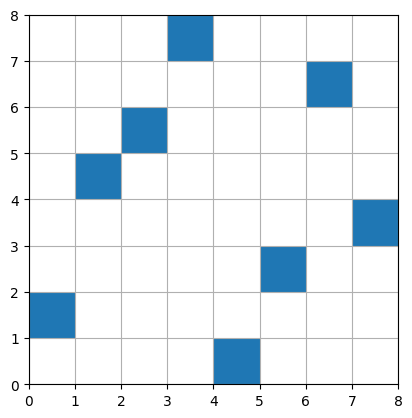

new generation ... 
recombination ...
mutations ... 
[[1, 7, 0, 5, 2, 4, 3, 6], [4, 7, 5, 0, 3, 2, 6, 1], [1, 2, 5, 0, 3, 7, 4, 6], [6, 3, 5, 2, 1, 0, 7, 4], [6, 3, 7, 2, 5, 0, 4, 1], [6, 3, 0, 7, 2, 1, 5, 4], [6, 3, 5, 0, 4, 2, 1, 7], [4, 0, 5, 2, 1, 7, 3, 6], [1, 5, 3, 6, 2, 7, 4, 0], [4, 0, 6, 3, 7, 5, 2, 1]]


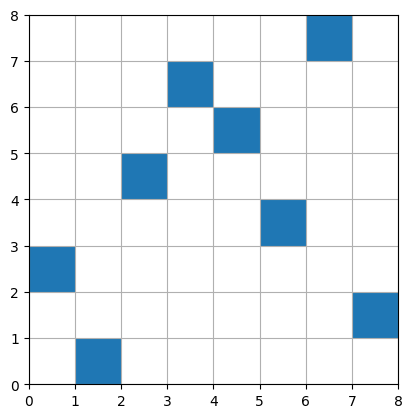

new generation ... 
recombination ...
mutations ... 
[[4, 0, 6, 3, 7, 1, 2, 5], [5, 2, 7, 0, 3, 6, 4, 1], [6, 3, 0, 7, 2, 5, 1, 4], [5, 2, 7, 0, 3, 6, 4, 1], [6, 3, 0, 5, 2, 1, 7, 4], [4, 5, 0, 7, 1, 2, 3, 6], [6, 3, 5, 2, 1, 7, 4, 0], [6, 0, 1, 5, 2, 7, 3, 4], [4, 1, 2, 5, 7, 0, 6, 3], [4, 7, 5, 2, 1, 0, 6, 3]]


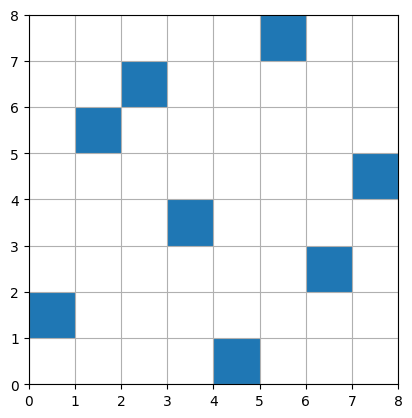

new generation ... 
recombination ...
mutations ... 
[[4, 0, 2, 5, 7, 1, 6, 3], [4, 5, 6, 3, 7, 2, 1, 0], [6, 7, 0, 2, 5, 1, 3, 4], [6, 3, 0, 7, 2, 1, 5, 4], [4, 1, 0, 7, 2, 5, 6, 3], [5, 2, 0, 7, 1, 6, 4, 3], [0, 2, 6, 4, 1, 5, 7, 3], [4, 0, 1, 7, 3, 6, 2, 5], [4, 6, 3, 2, 1, 7, 0, 5], [6, 5, 7, 0, 3, 1, 2, 4]]


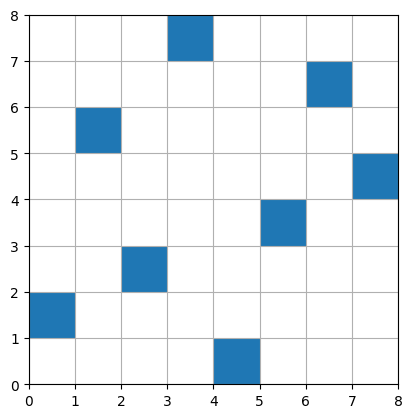

new generation ... 
recombination ...
mutations ... 
[[4, 5, 0, 7, 1, 2, 3, 6], [6, 0, 5, 2, 7, 1, 3, 4], [4, 1, 7, 0, 3, 5, 6, 2], [4, 5, 6, 3, 7, 2, 1, 0], [1, 7, 0, 2, 5, 6, 4, 3], [6, 3, 1, 5, 2, 0, 7, 4], [4, 5, 0, 7, 1, 2, 3, 6], [5, 1, 2, 7, 0, 3, 6, 4], [4, 6, 0, 7, 2, 1, 3, 5], [0, 1, 4, 7, 2, 6, 3, 5]]


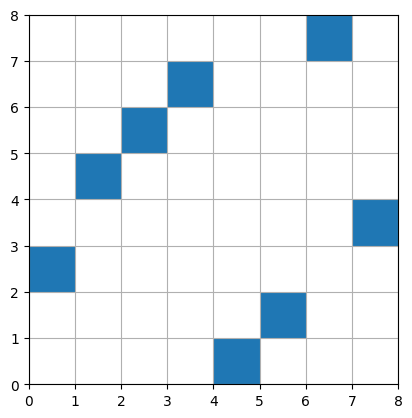

new generation ... 
recombination ...
mutations ... 
[[6, 2, 7, 0, 3, 5, 1, 4], [4, 3, 6, 1, 7, 5, 0, 2], [0, 5, 4, 7, 2, 1, 3, 6], [4, 0, 5, 2, 7, 1, 3, 6], [0, 7, 1, 5, 2, 6, 4, 3], [4, 7, 0, 2, 5, 3, 1, 6], [4, 7, 1, 5, 2, 0, 3, 6], [0, 5, 4, 7, 2, 1, 3, 6], [6, 2, 7, 0, 3, 1, 5, 4], [6, 2, 7, 0, 3, 1, 5, 4]]


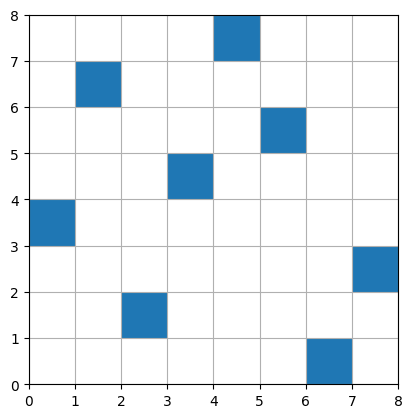

new generation ... 
recombination ...
mutations ... 
[[4, 7, 0, 5, 2, 1, 3, 6], [0, 2, 6, 1, 7, 5, 4, 3], [4, 2, 6, 1, 7, 0, 3, 5], [6, 5, 1, 3, 2, 0, 7, 4], [6, 2, 7, 0, 3, 1, 5, 4], [4, 3, 0, 2, 7, 5, 6, 1], [4, 1, 7, 0, 3, 2, 5, 6], [0, 1, 5, 2, 7, 6, 4, 3], [0, 4, 5, 1, 7, 2, 3, 6], [0, 5, 4, 2, 7, 3, 1, 6]]


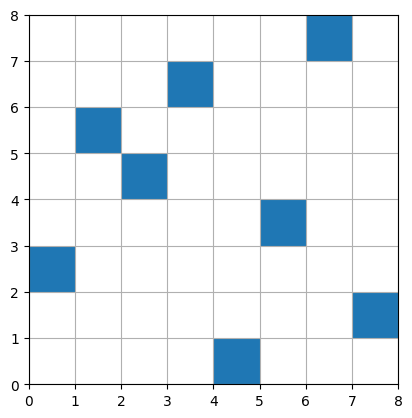

new generation ... 
recombination ...
mutations ... 
[[6, 1, 0, 2, 7, 5, 4, 3], [1, 2, 7, 0, 3, 5, 4, 6], [6, 3, 0, 5, 2, 1, 7, 4], [0, 7, 1, 2, 3, 6, 4, 5], [4, 2, 5, 1, 3, 0, 7, 6], [1, 4, 0, 5, 2, 7, 3, 6], [1, 4, 0, 5, 2, 7, 3, 6], [4, 3, 5, 1, 7, 0, 6, 2], [4, 2, 1, 5, 7, 0, 3, 6], [2, 4, 3, 0, 7, 5, 6, 1]]


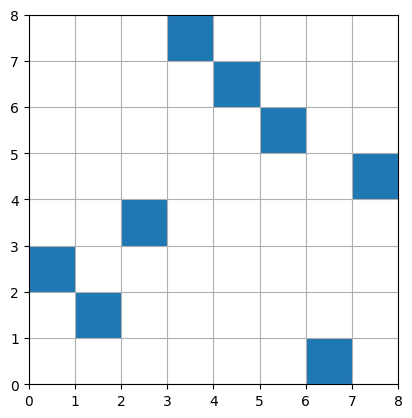

new generation ... 
recombination ...
mutations ... 
[[4, 2, 5, 1, 3, 0, 7, 6], [2, 1, 7, 4, 6, 3, 0, 5], [7, 4, 5, 0, 2, 3, 6, 1], [0, 3, 1, 5, 2, 6, 7, 4], [1, 2, 3, 0, 7, 5, 4, 6], [2, 1, 3, 0, 7, 6, 4, 5], [6, 3, 0, 5, 2, 1, 7, 4], [0, 4, 1, 2, 3, 7, 5, 6], [6, 2, 5, 1, 3, 0, 7, 4], [1, 7, 0, 5, 2, 6, 4, 3]]


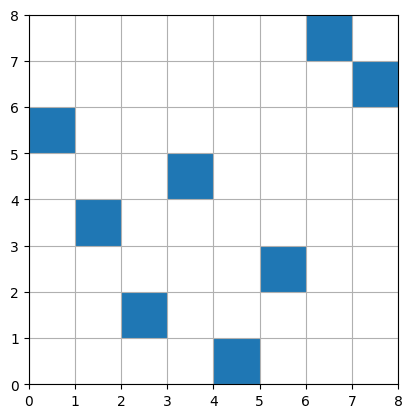

new generation ... 
recombination ...
mutations ... 
[[6, 3, 0, 5, 2, 1, 7, 4], [6, 2, 5, 1, 3, 0, 7, 4], [6, 7, 1, 5, 2, 3, 0, 4], [5, 2, 0, 1, 3, 6, 7, 4], [0, 3, 4, 5, 2, 1, 7, 6], [0, 3, 4, 5, 2, 1, 7, 6], [4, 7, 0, 3, 2, 1, 5, 6], [0, 7, 1, 5, 2, 3, 4, 6], [2, 0, 7, 4, 6, 3, 1, 5], [0, 7, 5, 1, 3, 6, 4, 2]]


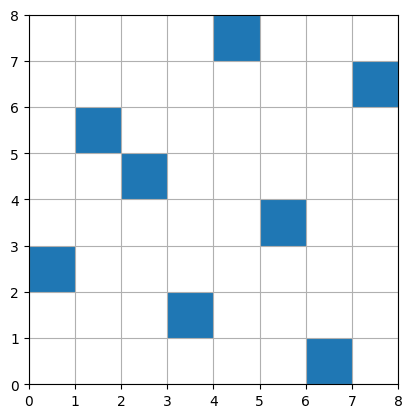

new generation ... 
recombination ...
mutations ... 
[[0, 3, 7, 6, 4, 1, 5, 2], [2, 4, 6, 3, 1, 0, 7, 5], [6, 3, 1, 5, 2, 0, 7, 4], [5, 1, 3, 6, 4, 7, 0, 2], [1, 0, 7, 4, 3, 2, 5, 6], [0, 5, 6, 4, 7, 3, 1, 2], [4, 2, 0, 6, 7, 5, 3, 1], [4, 7, 5, 1, 3, 2, 0, 6], [0, 7, 5, 1, 3, 2, 4, 6], [5, 1, 7, 4, 2, 0, 3, 6]]


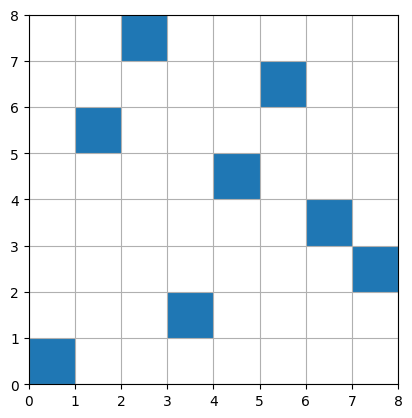

new generation ... 
recombination ...
mutations ... 
[[0, 5, 6, 3, 1, 4, 7, 2], [0, 2, 7, 5, 4, 6, 3, 1], [2, 1, 3, 6, 4, 0, 7, 5], [5, 1, 7, 4, 3, 6, 0, 2], [7, 3, 2, 6, 4, 5, 0, 1], [4, 6, 7, 5, 3, 2, 0, 1], [1, 0, 3, 6, 4, 2, 5, 7], [0, 5, 7, 6, 4, 2, 3, 1], [4, 0, 6, 5, 2, 1, 3, 7], [4, 7, 1, 5, 2, 0, 3, 6]]


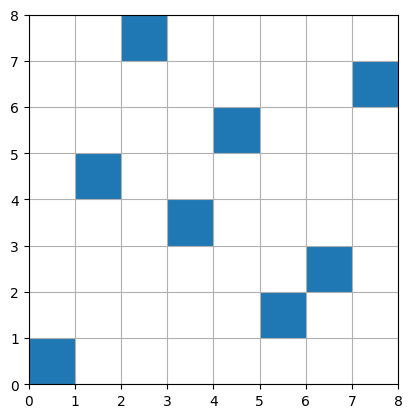

new generation ... 
recombination ...
mutations ... 
[[0, 4, 2, 5, 6, 7, 3, 1], [4, 1, 0, 5, 2, 6, 3, 7], [0, 5, 3, 6, 4, 1, 7, 2], [2, 1, 7, 5, 3, 0, 4, 6], [7, 3, 1, 5, 2, 6, 0, 4], [1, 0, 3, 6, 4, 2, 7, 5], [2, 4, 7, 5, 3, 6, 0, 1], [3, 4, 7, 0, 1, 2, 5, 6], [0, 5, 3, 6, 4, 1, 7, 2], [0, 5, 3, 6, 4, 2, 1, 7]]


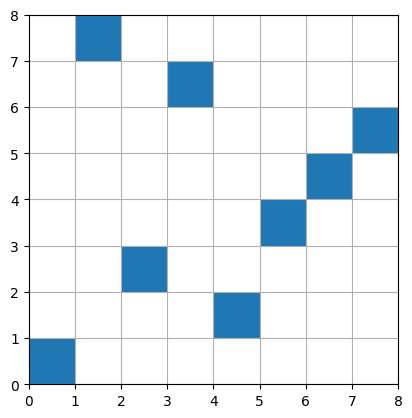

new generation ... 
recombination ...
mutations ... 
[[0, 6, 7, 5, 3, 2, 1, 4], [0, 5, 4, 6, 3, 7, 2, 1], [5, 7, 2, 1, 3, 6, 0, 4], [7, 1, 3, 6, 4, 5, 0, 2], [0, 2, 3, 5, 7, 4, 1, 6], [5, 4, 7, 0, 1, 2, 3, 6], [2, 7, 3, 6, 4, 5, 0, 1], [0, 7, 5, 6, 1, 2, 4, 3], [0, 5, 3, 6, 4, 7, 2, 1], [0, 1, 2, 5, 6, 3, 7, 4]]


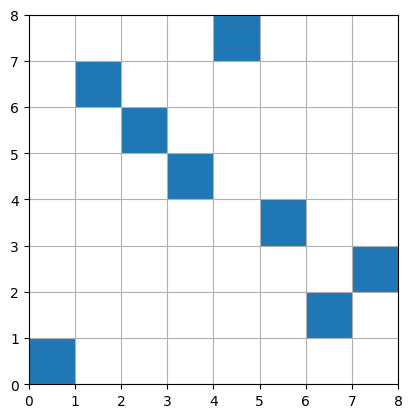

new generation ... 
recombination ...
mutations ... 
[[1, 7, 2, 5, 6, 3, 0, 4], [0, 1, 4, 6, 3, 5, 7, 2], [0, 6, 7, 5, 3, 4, 2, 1], [0, 7, 5, 1, 2, 4, 6, 3], [0, 1, 3, 6, 4, 2, 7, 5], [7, 1, 3, 6, 4, 5, 0, 2], [0, 1, 3, 2, 7, 5, 6, 4], [0, 2, 5, 6, 1, 4, 7, 3], [0, 6, 2, 4, 7, 5, 3, 1], [6, 5, 7, 0, 1, 4, 2, 3]]


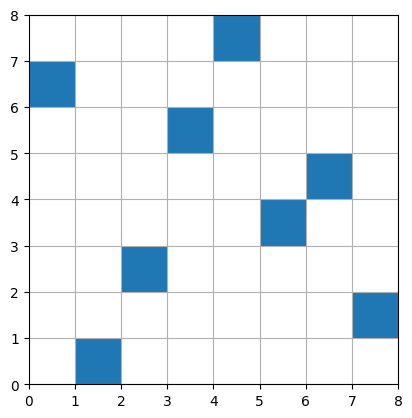

new generation ... 
recombination ...
mutations ... 
[[0, 7, 3, 6, 1, 5, 4, 2], [7, 1, 0, 5, 4, 6, 3, 2], [0, 1, 2, 5, 6, 3, 7, 4], [1, 3, 7, 4, 2, 6, 0, 5], [0, 6, 3, 1, 4, 5, 7, 2], [0, 3, 5, 6, 1, 4, 7, 2], [1, 0, 4, 6, 3, 2, 7, 5], [6, 7, 5, 1, 2, 3, 0, 4], [0, 6, 5, 1, 2, 4, 7, 3], [0, 6, 3, 5, 4, 7, 2, 1]]


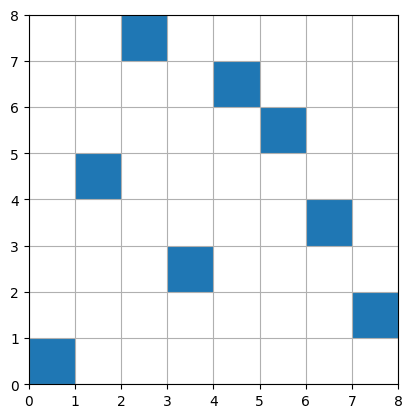

new generation ... 
recombination ...
mutations ... 
[[3, 6, 0, 5, 4, 7, 2, 1], [0, 6, 2, 4, 7, 1, 3, 5], [7, 0, 3, 6, 2, 1, 5, 4], [6, 0, 3, 1, 4, 2, 7, 5], [0, 1, 6, 5, 2, 4, 7, 3], [0, 5, 3, 1, 4, 7, 6, 2], [0, 5, 3, 6, 1, 2, 7, 4], [1, 4, 5, 3, 7, 6, 0, 2], [0, 5, 4, 6, 3, 7, 2, 1], [0, 3, 6, 5, 2, 7, 1, 4]]


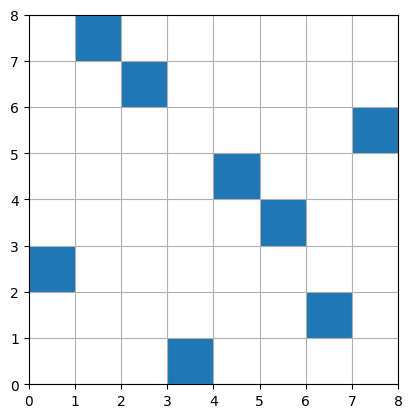

new generation ... 
recombination ...
mutations ... 
[[6, 3, 0, 5, 4, 7, 1, 2], [0, 4, 2, 3, 7, 6, 1, 5], [7, 5, 0, 3, 4, 1, 6, 2], [0, 5, 3, 4, 1, 7, 2, 6], [1, 5, 4, 3, 7, 6, 0, 2], [7, 0, 4, 6, 3, 1, 5, 2], [0, 2, 3, 6, 1, 4, 7, 5], [7, 5, 0, 3, 4, 1, 6, 2], [0, 1, 3, 6, 2, 4, 7, 5], [0, 5, 7, 4, 2, 3, 1, 6]]


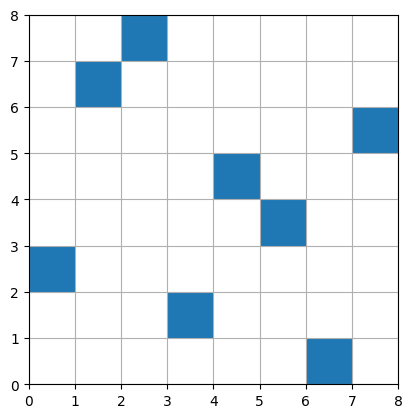

new generation ... 
recombination ...
mutations ... 
[[0, 2, 3, 6, 1, 4, 7, 5], [0, 2, 4, 3, 7, 6, 1, 5], [6, 2, 5, 7, 1, 4, 3, 0], [7, 5, 3, 4, 1, 2, 0, 6], [4, 7, 0, 6, 2, 1, 5, 3], [7, 0, 3, 6, 2, 1, 5, 4], [0, 4, 5, 3, 7, 1, 6, 2], [0, 1, 2, 3, 7, 4, 6, 5], [7, 3, 0, 5, 4, 2, 6, 1], [7, 0, 4, 6, 3, 1, 2, 5]]


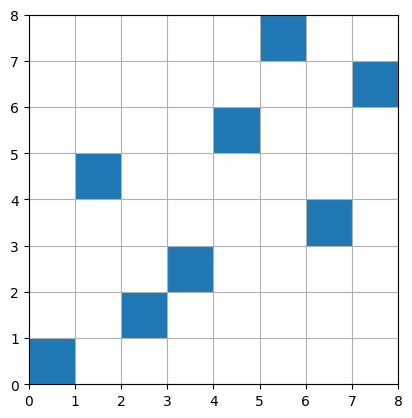

new generation ... 
recombination ...
mutations ... 
[[7, 5, 4, 2, 6, 3, 1, 0], [4, 3, 5, 7, 1, 2, 0, 6], [0, 4, 2, 3, 7, 1, 6, 5], [6, 7, 3, 4, 1, 2, 5, 0], [0, 7, 3, 6, 2, 4, 1, 5], [0, 2, 5, 7, 4, 1, 6, 3], [1, 5, 2, 3, 7, 4, 6, 0], [2, 0, 5, 3, 4, 6, 1, 7], [7, 3, 0, 5, 4, 1, 2, 6], [0, 2, 3, 5, 7, 6, 1, 4]]


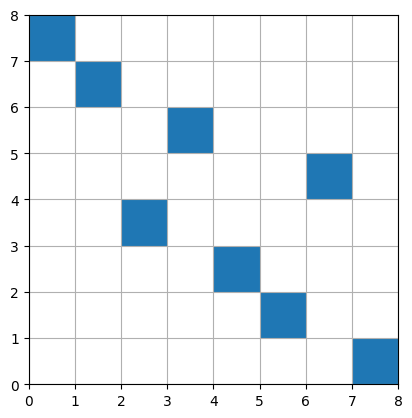

new generation ... 
recombination ...
mutations ... 
[[0, 2, 3, 5, 7, 6, 1, 4], [1, 5, 2, 3, 7, 4, 6, 0], [0, 6, 2, 3, 7, 4, 1, 5], [4, 3, 2, 5, 7, 1, 0, 6], [7, 4, 3, 5, 6, 2, 1, 0], [2, 0, 5, 7, 1, 6, 4, 3], [0, 4, 2, 3, 7, 1, 6, 5], [0, 6, 2, 3, 7, 4, 1, 5], [2, 6, 3, 4, 7, 5, 1, 0], [7, 5, 3, 0, 1, 4, 2, 6]]


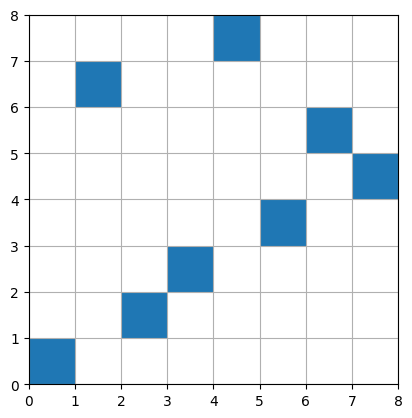

new generation ... 
recombination ...
mutations ... 
[[2, 6, 3, 4, 5, 7, 1, 0], [3, 4, 6, 5, 7, 2, 1, 0], [5, 2, 3, 4, 7, 1, 0, 6], [1, 2, 0, 7, 4, 6, 5, 3], [2, 3, 0, 5, 7, 6, 4, 1], [4, 6, 2, 3, 7, 5, 1, 0], [7, 5, 1, 0, 3, 4, 6, 2], [0, 6, 2, 3, 7, 4, 1, 5], [1, 5, 2, 0, 4, 7, 3, 6], [2, 6, 5, 7, 1, 3, 4, 0]]


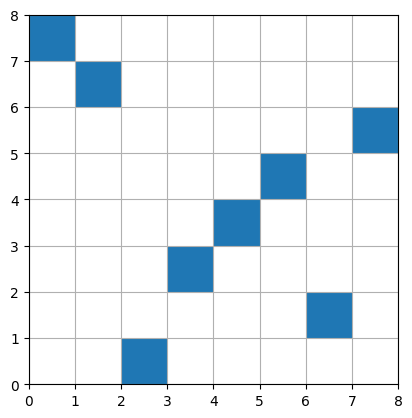

new generation ... 
recombination ...
mutations ... 
[[0, 2, 6, 4, 7, 5, 1, 3], [4, 6, 0, 5, 7, 3, 1, 2], [5, 2, 0, 7, 4, 1, 3, 6], [3, 7, 4, 0, 2, 6, 1, 5], [3, 6, 0, 7, 4, 5, 1, 2], [1, 5, 0, 7, 4, 3, 6, 2], [6, 5, 3, 4, 7, 2, 1, 0], [1, 5, 2, 3, 7, 4, 0, 6], [4, 6, 2, 3, 7, 5, 0, 1], [3, 7, 2, 5, 1, 6, 4, 0]]


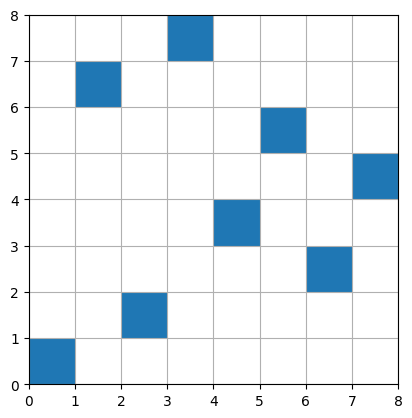

final answer is [5, 2, 0, 7, 4, 1, 3, 6]


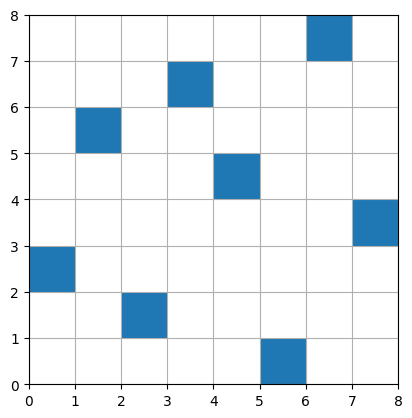

In [19]:
final_answer = genetic_n_queens(n,10,chromosom)
print(str.format("final answer is {0}",final_answer))
plot_solution([final_answer],n)
